In [1]:
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pymc3 as pm
import scipy.stats as stats
import seaborn as sns
import pandas as pd

This is based on the [homework of week 2](https://github.com/rmcelreath/statrethinking_winter2019/blob/master/homework/week02.pdf) of Statistical Rethinking book material.
I do the homework based on the questions but not following a specific order.
<br>
<br>
The reference dataset is the [Kalahari !Kung San people](https://www.tensorflow.org/datasets/catalog/howell).

Loading the !Kung dataset

In [5]:
df = pd.read_csv("../Data/Howell1.csv", sep=";")
df.head()

,height,weight,age,male
0,151.765,47.825606,63.0,1
1,139.700,36.485807,63.0,0
2,136.525,31.864838,65.0,0
3,156.845,53.041915,41.0,1
4,145.415,41.276872,51.0,0


Taking a look at the range of ages of the dataset.

<AxesSubplot:xlabel='age'>

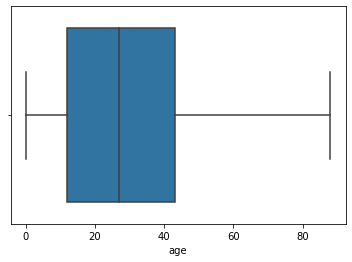

In [85]:
sns.boxplot(df['age'])

Creating a model.
As for the priors **a** is the height for when the weight is equal to the mean of weights.<br> 
As the dataset is composed mainly of teenagers and adults, I chose the mean of height as 150cm with a standard deviation of 20cm, which means that 95% of the heights are concentrated between 110cm and 190cm.   
<br>
Doing a simple regression we have the following:

In [6]:
x_bar = df['weight'].mean()

with pm.Model() as m_1:
    a = pm.Normal('a', 150, 20)
    bW = pm.Normal('bW', 0, 10)
    
    sigma = pm.Exponential('sigma', 1)
    
    mu = pm.Deterministic('mu', a + bW*(df['weight']) - x_bar)
    height = pm.Normal('height', mu=mu, sigma=sigma, observed=df['height'])
    
    m1_trace = pm.sample(tune=2000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, bW, a]
Sampling 4 chains, 0 divergences: 100%|██████████| 10000/10000 [00:03<00:00, 3326.24draws/s]


In [7]:
varnames = ['~mu']
az.summary(m1_trace, varnames, round_to=2, kind="stats")

/home/elisio/anaconda3/lib/python3.7/site-packages/arviz/data/io_pymc3.py:91: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,


,mean,sd,hdi_3%,hdi_97%
a,111.18,1.05,109.11,113.06
bW,1.76,0.03,1.71,1.81
sigma,9.31,0.28,8.83,9.90


In [88]:
mu_pred = m1_trace['mu']
mu_mean = mu_pred.mean(0)

Text(0, 0.5, 'height')

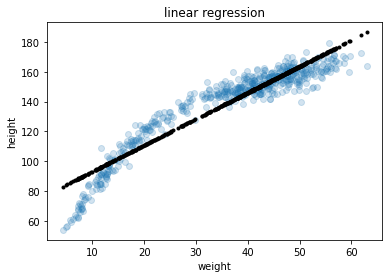

In [94]:
plt.scatter(df.weight, df.height, alpha=0.2)
plt.plot(df.weight, mu_mean, '.', color='black')# color='black')#, color='black', '.')
plt.title('linear regression')
plt.xlabel('weight')
plt.ylabel('height')

Not a good fit as we can see.

---

**Model the relationship between height(cm) and the natural logarithm of weight(log-kg)**

In [95]:
df['weight_log'] = np.log(df['weight'])
df.head()

,height,weight,age,male,weight_log
0,151.765,47.825606,63.0,1,3.867561
1,139.700,36.485807,63.0,0,3.596923
2,136.525,31.864838,65.0,0,3.461503
3,156.845,53.041915,41.0,1,3.971082
4,145.415,41.276872,51.0,0,3.720302


In [96]:
x_bar = df['weight_log'].mean()

with pm.Model() as m_2:
    a = pm.Normal('a', 150, 20)
    bM = pm.Lognormal('bM', 0, 5)
    #cM = pm.Normal('cM', 0, 10)
    
    #mu = pm.Deterministic('mu', a + bM*(df['weight_log'] - x_bar) + cM*np.power((df['weight_log'] - x_bar),2))
    #mu = pm.Deterministic('mu', a + bM*(df['weight_log'] - x_bar) + cM*np.power((df['weight_log'] - x_bar),2))
    mu = pm.Deterministic('mu', a + bM*(df['weight_log'] - x_bar))
    sigma = pm.Exponential('sigma', 1)
    
    height = pm.Normal('height', mu=mu, sigma=sigma, observed=df['height'])
    
    m2_trace = pm.sample(tune=4000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, bM, a]
Sampling 4 chains, 0 divergences: 100%|██████████| 18000/18000 [00:03<00:00, 5823.59draws/s]


In [97]:
varnames = ["~mu"]
az.summary(m2_trace, varnames, round_to=2, kind="stats")

/home/elisio/anaconda3/lib/python3.7/site-packages/arviz/data/io_pymc3.py:91: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,


,mean,sd,hdi_3%,hdi_97%
a,138.26,0.23,137.82,138.68
bM,47.08,0.39,46.35,47.78
sigma,5.13,0.15,4.84,5.40


In [98]:
mu_pred = m2_trace['mu']
mu_mean = mu_pred.mean(0)

Text(0, 0.5, 'height')

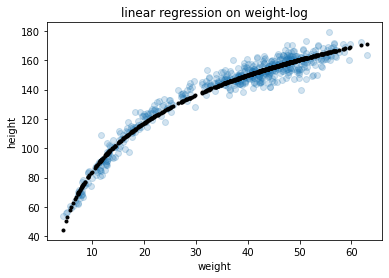

In [103]:
plt.scatter(df.weight, df.height, alpha=0.2)
plt.plot(df.weight, mu_mean, '.', color='black')
plt.title('linear regression on weight-log')
plt.xlabel('weight')
plt.ylabel('height')

---

In [52]:
with m_2:
    height_pred = pm.sample_posterior_predictive(trace=m2_trace, vars=[height], size=200)

100%|██████████| 2000/2000 [00:08<00:00, 246.63it/s]


/home/elisio/anaconda3/lib/python3.7/site-packages/arviz/stats/stats.py:487: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  FutureWarning,
/home/elisio/anaconda3/lib/python3.7/site-packages/arviz/data/base.py:153: UserWarning: More chains (2000) than draws (200). Passed array should have shape (chains, draws, *shape)
  UserWarning,


Text(0, 0.5, 'height')

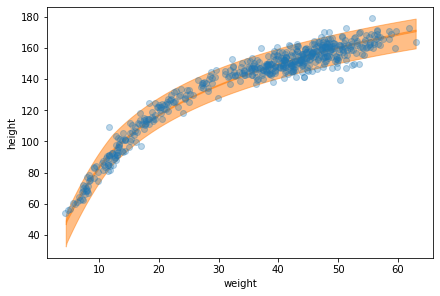

In [74]:
ax = az.plot_hdi(df.weight, mu_pred, hdi_prob=0.89)
az.plot_hdi(df.weight, height_pred['height'], ax=ax)
plt.scatter(df.weight, df.height, alpha=0.3)
#plt.plot(df.weight_log, mu_mean, color='black')# color='black')#, color='black', '.')
plt.xlabel('weight')
plt.ylabel('height')

In [5]:
def standardize(series):
    return (series - series.mean())/series.std()

**Select out all the rows in the Howell1 data with ages below 18 years of age. If you do it right, you should end up with a new data frame with 192 rows in it.**

In [6]:
df = df.loc[df['age'] < 18]
df['weight_std'] = standardize(df['weight'])
df['height_std'] = standardize(df['height'])
df['age_std'] = standardize(df['age'])
df['weight_log'] = np.log(df['weight'])
df.head()

,height,weight,age,male,weight_std,height_std,age_std,weight_log
18,121.92,19.617854,12.0,1,0.134648,0.528300,0.797230,2.976440
19,105.41,13.947954,8.0,0,-0.499618,-0.112986,0.051829,2.635333
20,86.36,10.489315,6.5,0,-0.886520,-0.852932,-0.227697,2.350357
23,129.54,23.586784,13.0,1,0.578634,0.824278,0.983581,3.160687
24,109.22,15.989118,7.0,0,-0.271282,0.035003,-0.134522,2.771908


In [7]:
df.weight

18     19.617854
19     13.947954
20     10.489315
23     23.586784
24     15.989118
         ...    
535    17.519991
536     7.229123
538     8.022908
539    31.127751
542     8.051258
Name: weight, Length: 192, dtype: float64

**(a) Fit a linear regression to these data, using quap. Present and interpret the estimates. For
every 10 units of increase in weight, how much taller does the model predict a child gets?**

In [8]:
xbar = df['weight_std'].mean()

with pm.Model() as m_kung:
    a = pm.Normal('a', 150, 20)
    bW = pm.Lognormal('bW', 0, 10)
    
    sigma = pm.Exponential('sigma', 1)
    
    mu = pm.Deterministic('mu', a + bW*(df['weight_std']) - xbar)
    height = pm.Normal('height', mu=mu, sigma=sigma, observed=df['height_std'])
    
    kung_trace = pm.sample(2000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, bW, a]
Sampling 4 chains, 391 divergences: 100%|██████████| 10000/10000 [00:17<00:00, 568.85draws/s]
The acceptance probability does not match the target. It is 0.9997666717737094, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.999717741469096, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9991395159374777, but should be close to 0.8. Try to increase the number of tuning steps.
There were 391 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.14414111931342746, but should be close to 0.8. Try to increase the number of tuning steps.
The rhat statistic is larger than 1.05 for some parameters. This indicate

In [9]:
varnames = ['~mu']
az.summary(kung_trace, varnames, round_to=2, kind="stats")

/home/elisio/anaconda3/lib/python3.7/site-packages/arviz/data/io_pymc3.py:91: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,


,mean,sd,hdi_3%,hdi_97%
a,0.00,0.02,-0.05,0.05
bW,0.94,0.02,0.90,0.98
sigma,0.33,0.02,0.30,0.37


For every 10 units of increase in weight the model predicts that the child will be 45.1 cm taller.

**(b) Plot the raw data, with height on the vertical axis and weight on the horizontal axis. Superimpose the MAP regression line and 89% interval for the mean. Also superimpose the 89% interval for predicted heights.**

In [10]:
with m_kung:
    height_pred = pm.sample_posterior_predictive(trace=kung_trace, vars=[height], size=200)

100%|██████████| 8000/8000 [00:16<00:00, 498.42it/s]


In [11]:
mu_pred = kung_trace['mu']
mu_mean = mu_pred.mean(0)

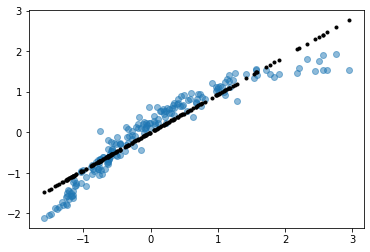

In [12]:
plt.scatter(df.weight_std, df.height_std, alpha=0.5)
plt.plot(df.weight_std, mu_mean, '.', color='black')# color='black')#, color='black', '.')

/home/elisio/anaconda3/lib/python3.7/site-packages/arviz/stats/stats.py:487: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  FutureWarning,
/home/elisio/anaconda3/lib/python3.7/site-packages/arviz/data/base.py:153: UserWarning: More chains (8000) than draws (200). Passed array should have shape (chains, draws, *shape)
  UserWarning,


Text(0.5, 0, 'height')

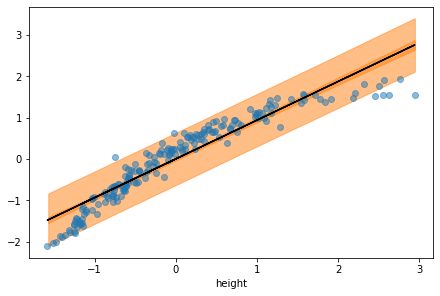

In [13]:
ax = az.plot_hdi(df.weight_std, mu_pred, hdi_prob=0.89)
az.plot_hdi(df.weight_std, height_pred['height'], ax=ax)
plt.scatter(df.weight_std, df.height_std, alpha=0.5)
plt.plot(df.weight_std, mu_mean, color='black')# color='black')#, color='black', '.')
plt.xlabel('weight')
plt.xlabel('height')

---

**Making some predictions of height and 89% interval, with the model, for the table below.**

Table to be filled with predictions

In [18]:
df_pred = pd.DataFrame({'individual':[1 , 2, 3, 4, 5],
                        'weight':[45, 40, 65, 31, 53],
                        'exp_height':[0, 0, 0, 0, 0],
                        'interval_89':['', '', '', '', '']})
df_pred

,individual,weight,exp_height,interval_89
0,1,45,0,
1,2,40,0,
2,3,65,0,
3,4,31,0,
4,5,53,0,


Below we fill the table with the predictions for expected height and the 89% interval.

In [19]:
for i in range(df_pred.shape[0]):
    # expected height
    exp_height = kung_trace['a'] + kung_trace['bW']*[df_pred['weight'][i]-df.weight.mean()] 
    df_pred.loc[i, 'exp_height'] = exp_height.mean()
    
    # 89% interval
    df_pred.loc[i, 'interval_89'] = str(az.hdi(exp_height, hdi_prob=.89))

In [20]:
df_pred

,individual,weight,exp_height,interval_89
0,1,45,127.719836,[126.38863356 129.01166655]
1,2,40,118.913985,[117.33658933 120.343153 ]
2,3,65,162.943237,[162.27618146 163.65839123]
3,4,31,103.063455,[101.1534733 104.86093871]
4,5,53,141.809196,[140.77859191 142.80320464]
